# Spam/Ham Classification

## Feature Engineering, Classification, and Cross Validation

In [3]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

## Loading and Cleaning Data

Our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). The labeled training dataset contains 8,348 labeled examples, and the unlabeled test set contains 1,000 unlabeled examples.

Load in the data into a `DataFrame`.

The `train` DataFrame contains labeled data that we will use to train our model. It contains four columns:

1. `id`: An identifier for the training example.
1. `subject`: The subject of the email.
1. `email`: The text of the email.
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam).

The `test` DataFrame contains 1,000 unlabeled emails. We will predict labels for these emails.

In [5]:
import zipfile
with zipfile.ZipFile('spam_ham_data.zip') as item:
    item.extractall()

In [6]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [7]:
# Fill any missing or NAN values
print('Before imputation:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After imputation:')
print(original_training_data.isnull().sum())

Before imputation:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After imputation:
id         0
subject    0
email      0
spam       0
dtype: int64


## Training/Validation Split

The training data we downloaded is all the data we have available for both training models and **validating** the models that we train. We therefore split the training data into separate training and validation datsets. WeYou will use this **validation data** to assess the performance of the classifier. 

In [8]:
# This creates a 90/10 train-validation split on our labeled data.
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train = train.reset_index(drop = True)

## Feature Engineering

In order to train a logistic regression model, we need a numeric feature matrix $\mathbb{X}$ and a vector of corresponding binary labels $\mathbb{Y}$. To address this, we implemented the function `words_in_texts`, which creates numeric features derived from the email text and uses those features for logistic regression. 

The function outputs a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. 

In [9]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        A 2D NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    import numpy as np
    indicator_array = 1 * np.array([texts.str.contains(word) for word in words]).T
    return indicator_array

In [10]:
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

In [11]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'lbfgs')
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers

In our models, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. 

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- **False Positive (FP)**: A ham email gets flagged as spam and filtered out of the inbox.
- **False Negative (FN)**: A spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision**: Measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall**: Measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False positive rate**: Measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam.

Note that a True Positive (TP) is a spam email that is classified as spam, and a True Negative (TN) is a ham email that is classified as ham.

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

Building Our Own Model
---

In [13]:
# Define processing function, processed data, and model here. 
import re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

def consecutive_uppercase(string):
        if re.search(r'(\b[A-Z]+\b\s){2,}\b[A-Z]+\b', string):
            return 1
        else:
            return 0

def spam_words_count(string):
    spam_words = ['asap', 'vip', 'grow', 'affordable', 'debt', 'domain', 'discount', 'foreign', 'tracked', 'nasty', 'click', 'horny', 'penis', 'wife', 'million', 'millions', 'girlfriend', 'length', 'sex', 'thickness', 'cheating', 'membership', 'myth', 'assistance', 'credit', 'loan', 'help', 'viagra', 'free', 'subscribe']
    count = 0
    string = string.lower().split(' ')
    for word in string:
        if word in spam_words:
            count += 1
        else:
            count += 0 
    return count

def find_repetitive(string):
    string = string.split(' ')
    count = 0
    for item in string:
        if len(item) > 12:
            count += 1
        else:
            count += 0 
    return count

#Create columns in the df w/ 1 if it has the feature and 0 else; also includes some counts
def find_features(data_set):
    data_set['subject_$'] = data_set['subject'].astype(str).apply(lambda x: 1 if re.search(r'\$', x) else 0)
    data_set['email_$'] = data_set['email'].astype(str).apply(lambda x: 1 if re.search(r'\$', x) else 0)
    data_set['subject_all_caps'] = data_set['subject'].astype(str).apply(lambda x: consecutive_uppercase(x))
    #data_set['email_all_caps'] = data_set['email'].astype(str).apply(lambda x: consecutive_uppercase(x))
    #data_set['mime_format'] = data_set['email'].astype(str).apply(lambda x: 1 if re.search(r'This is a multi-part message in MIME format.', x, re.IGNORECASE) else 0)
    data_set['html'] = data_set['email'].astype(str).apply(lambda x: 1 if re.search(r'<html>', x, re.IGNORECASE) else 0)
    data_set['repetitive_str_email'] = data_set['email'].astype(str).apply(lambda email_content: find_repetitive(email_content))
    data_set['fw'] = data_set['subject'].astype(str).apply(lambda x: 1 if re.search(r'fw:', x, re.IGNORECASE) else 0)
    data_set['re'] = data_set['subject'].astype(str).apply(lambda x: 1 if re.search(r're:', x, re.IGNORECASE) else 0)
    data_set['subject_spam_word_count'] = data_set['subject'].astype(str).apply(lambda subject_line: spam_words_count(subject_line)) 
    data_set['email_spam_word_count'] = data_set['email'].astype(str).apply(lambda email_content: spam_words_count(email_content)) 
                                                                    
    return data_set     

In [14]:
find_features(train)
X_train = train.iloc[:, 4:]
Y_train = train['spam']

find_features(test)
X_test = test.iloc[:, 3:]

model = LogisticRegression()
model.fit(X_train, Y_train)
Y_train_predictions = model.predict(X_train)
Y_hat = model.predict(X_test)
model.score(X_train, Y_train)

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.872753893251697

1. To find the best features for the model, I looked at the train data csv file. I tried to find similarities between the subject lines and email content of the emails that were marked as spam. However, I had to also look at ham emails to ensure that I wasn't selecting vague features that were present in both types of emails. I also thought about what I notice in the spam emails from my own inbox. I used that background knowledge to select features that could distinguish spam from ham.
2. I initially focused on the content of the emails. I created a very large list of words that were common in spam emails and tried to use that to train the model. However, words alone were not enough for the model. Many words were common in both types of emails and I ran into the issue of overfitting. I was selecting words directly from spam emails which made for an inflexible model that did not work very well on the validation set. This also resulted in an inefficient run time. When I focused on broader similarities such as html tags and repetitive strings, I was able to increase the model accuracy and improve the runtime. This method also eliminated the issue of overfitting since I was looking at general similarities as opposed to exact words. Adding these features allowed the model to perform well on the validation and test sets.
3. I was surprised how simple changes to existing features can dramatically affect the model's performance. For example, in my initial implementation of the 'html' feature, I was only looking at emails whose content started with an html tag. Additionally, my original regex expression ignored uppercase and other formats of html tags. When I fixed the feature by having it include emails where the html tag was in the middle of the content and consider varying case formats, my accuracy went up significantly. The model was able to identify spam emails with a much higher accuracy. Similarly, when I started looking for repetitive strings, I was using 20 characters (without a whitespace) as the threshold for a repetitive string. However, my accuracy improved when I lowered this boundary to at least 12 characters without a whitespace. Both of these instances taught me that developing features can be a difficult task that requires a lot of fine tuning and critical thinking. 

<Axes: >

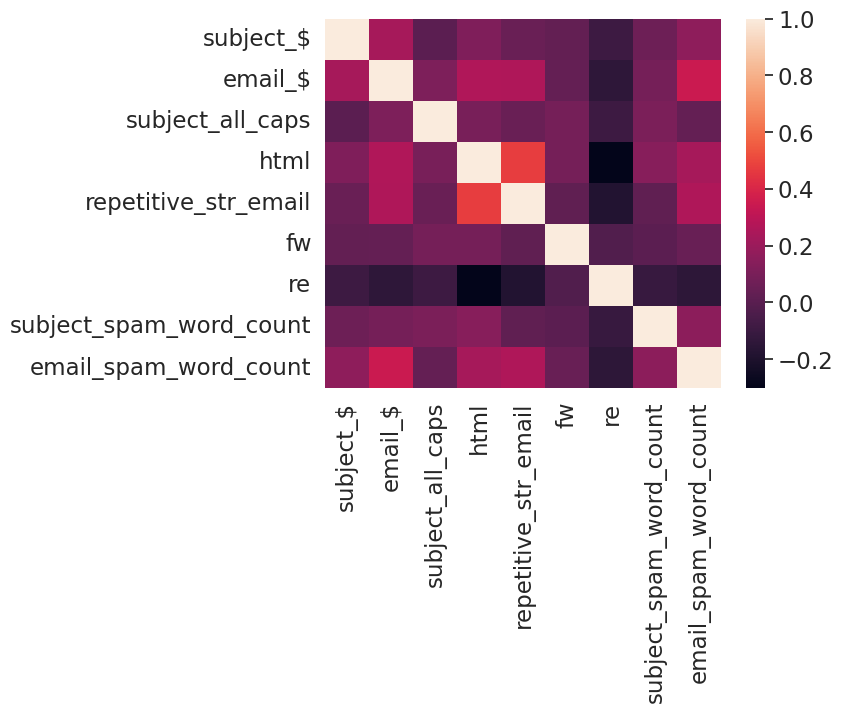

In [15]:
sns.heatmap(X_train.corr())

The heatmap above displays the correlation between the various features in the model. In a heatmap, the correlation between each pair of features is represented by a color, with warmer colors indicating stronger positive correlations, and cooler colors indicating stronger negative correlations. A diagonal line of the same color is often shown to indicate a feature's correlation with itself, which is always perfect and therefore, not very useful.

One of the main advantages of using a heatmap to analyze a classification model's feature correlations is that it can reveal redundant features. Redundant features are those that are highly correlated with one another and provide essentially the same information to the model. When two or more features are highly correlated, it can result in overfitting and decreased model performance, as well as increased computation time and complexity. In my model, the features I selected generally do not have a high correlation between one another. The highest correlation and most likely form of redundancy is between the 'html' feature and the 'repetitive_str_email' (indicates whether an email's body contains long, non-word strings) feature. However, this correlation is still only between 0.5 and 0.6 which is not a major indicator of redundancy.

The lack of strong correlations between my features indicates that this model does not overfit and little redudancy. If the heatmap showed a stronger correlation between features, then I would have reassesed which features to train the model on. I could have potentially removed redundant features to improve accuracy, adaptability, and runtime. Although that is not the case with my model, it is a good tool and note to keep in mind for future feature engineering.

/srv/conda/envs/notebook/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


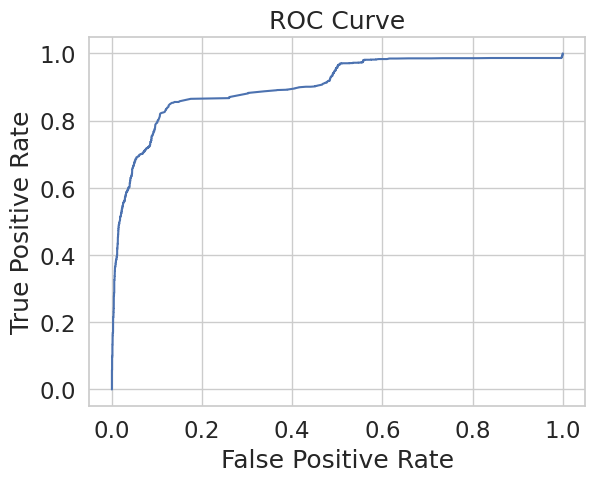

In [16]:
from sklearn.metrics import roc_curve

model_2 = LogisticRegression()
model_2.fit(X_train, Y_train)
Y_train_predictions_2 = model_2.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_train, Y_train_predictions_2)

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr)

In [17]:
train_predictions = Y_train_predictions

In [18]:
test_predictions = Y_hat

The following cell generates a CSV file with the predictions.

In [19]:
from datetime import datetime
from IPython.display import display, HTML

submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = "submission_{}.csv".format(timestamp)
submission_df.to_csv(filename, index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
display(HTML("Download your test prediction <a href='" + filename + "' download>here</a>."))
print('You may now upload this CSV file.')

Created a CSV file: submission_20240403_194522.csv.


You may now upload this CSV file.
